# Import libraries

In [1]:
import gensim, logging
import smart_open, os
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import datetime
import collections, math, os, random, zipfile
import pandas as pd
import utils
from scipy import sparse
import numpy as np
import seaborn as sns


from pathlib import Path

# Prepare input data

In [3]:
word_embedding_model_name = "GLOVE"
files =  os.listdir("../wikipedia/data")
now = str(datetime.datetime.now()).replace(" ","")
vocabulary_size = 1000000

In [4]:
#Create a unique file big with one wikipedia page per line
path="../wikipedia/data/"
if not os.path.exists('./data/wikipedia_informatic.txt'):
    if not os.path.exists('./data'):
        os.mkdir('./data')
    with open('./data/wikipedia_informatic.txt', 'w+',encoding="utf8" ) as out_file:
        for file in files:
            if "ipynb_checkpoints" in file:
                continue
            try:
                with open(path + file, encoding="utf8") as in_file:
                    out_file.write(in_file.read().replace("\n",""))
            except:
                continue

# We tokenize the file
with open('./data/wikipedia_informatic.txt', 'r', encoding="utf8") as f:
    wiki_vocab = f.readlines()
wiki_vocab = [x.strip() for x in wiki_vocab] 
wiki_vocab_tokenized = []
wiki_vocab_tokenized = gensim.utils.simple_preprocess(str(wiki_vocab))

NameError: name 'wiki_vocab' is not defined

# Construct dictionnary

In [2]:

def build_dataset(vocab_tokenized):
    dictionary_count = {}
    dictionary_count['UNK'] = -1
    dictionary_count.update(collections.Counter(vocab_tokenized))

    
    dictionary = {word: (i, freq) for i, (word, freq) in enumerate(dictionary_count.items())}
    
    reverse_dictionary = dict((i, word) for word, (i, _) in dictionary.items())
    
    return dictionary, reverse_dictionary, dictionary_count



dictionary, reverse_dictionary, dictionary_count = build_dataset(wiki_vocab_tokenized)

NameError: name 'wiki_vocab_tokenized' is not defined

# Create Matrice co-occurence

In [145]:
# cooccur_test = glove.build_cooccur(vocab, wiki_vocab_test, window_size=10)

In [146]:
#def build_co_occurence_matrice

In [147]:
def build_co_occurence_matrice(corpus, dictionary, reverse_dictionary, window_size):
    
    vocab_size = len(dictionary)
    

    cooccurrences = sparse.lil_matrix((vocab_size, vocab_size),dtype=np.float32)
    for i, line in enumerate(corpus):
        print(line)
        if i % 1 == 0:
            print("Building cooccurrence matrix: on line %i", i)

        words = line.strip().split()
        words_ids = [dictionary[word][0] for word in words]


        for i, word_id in enumerate(words_ids):
            context_ids = words_ids[max(0, i - window_size) : i]
            contexts_len = len(context_ids)

            for j, left_id in enumerate(context_ids):
                # Distance from center word
                distance = contexts_len - j

                # Weight by inverse of distance between words
                weight = 1.0 / float(distance)
                cooccurrences[word_id, left_id] += weight
                cooccurrences[left_id, word_id] += weight

    return cooccurrences

In [135]:
cooccurrences = build_co_occurence_matrice(corpus_test, dictionary_test, reverse_dictionary, 3)

human interface computer
Building cooccurrence matrix: on line %i 0
survey user computer system response time
Building cooccurrence matrix: on line %i 1
eps user interface system
Building cooccurrence matrix: on line %i 2
system human system eps
Building cooccurrence matrix: on line %i 3
user response time
Building cooccurrence matrix: on line %i 4
trees
Building cooccurrence matrix: on line %i 5
graph trees
Building cooccurrence matrix: on line %i 6
graph minors trees
Building cooccurrence matrix: on line %i 7
graph minors survey
Building cooccurrence matrix: on line %i 8
i like graph and stuff
Building cooccurrence matrix: on line %i 9
i like trees and stuff
Building cooccurrence matrix: on line %i 10
sometimes i build a graph
Building cooccurrence matrix: on line %i 11
sometimes i build trees
Building cooccurrence matrix: on line %i 12


### Print matrice

In [148]:

def print_matrice(cooccurrences, dictionary):
    df_cm = pd.DataFrame(cooccurrences.toarray(),columns=list(dictionary.keys()), index=list(dictionary.keys()))

    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.heatmap(df_cm, annot=True)
    return ax

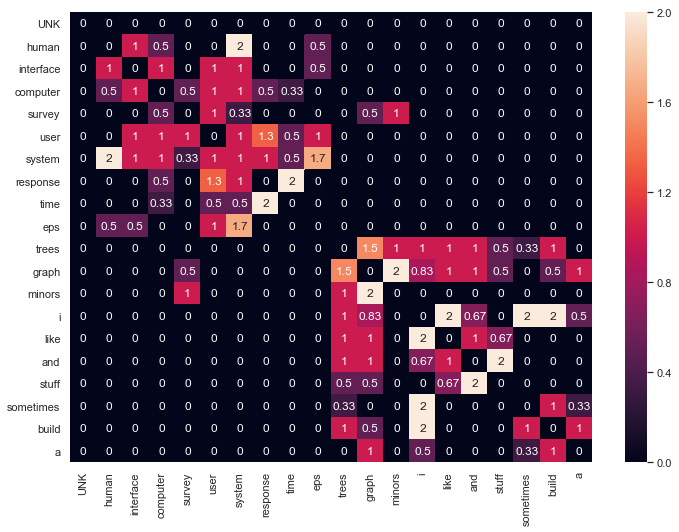

In [149]:
dictionary = dictionary_test
print_matrice(cooccurrences, dictionary_test)

In [151]:
dictionary_count

{'UNK': -1,
 'human': 2,
 'interface': 2,
 'computer': 2,
 'survey': 2,
 'user': 3,
 'system': 4,
 'response': 2,
 'time': 2,
 'eps': 2,
 'trees': 5,
 'graph': 5,
 'minors': 2,
 'i': 4,
 'like': 2,
 'and': 2,
 'stuff': 2,
 'sometimes': 2,
 'build': 2,
 'a': 1}

In [155]:
def glove_weight(values, alpha=0.75, x_max=100):
    return np.clip(np.power(values / x_max, alpha), 0, 1)

In [156]:
coo = cooccurrences.tocoo(copy=False)

# Access `row`, `col` and `data` properties of coo matrix.
df = pd.DataFrame({'word_index': coo.row, 'word_col': coo.col, 'value': coo.data}
                 )[['word_index', 'word_col', 'value']].sort_values(['word_index', 'word_col']
                 ).reset_index(drop=True)
df['main_word'] = df.apply(lambda row: reverse_dictionary[int(row.word_index)], axis=1)
df['context_word'] = df.apply(lambda row: reverse_dictionary[int(row.word_col)], axis=1)
df['count'] = df.apply(lambda row: reverse_dictionary[int(row.word_col)], axis=1)
df['glove_value'] = df.apply(lambda row: np.log(row.value), axis=1)
df['glove_weight'] = df.apply(lambda row:glove_weight(row.value), axis=1)

In [158]:
df.to_csv("data/glove_preparation.csv")

In [160]:
data = {"vocabulary": reverse_dictionary, "interaction": df}

In [169]:
def save_data(data, save_dir="data"):
    # save vocab
    vocab = data["vocabulary"]
    file_path = Path(save_dir, "vocab.json")
    with open(file_path, "w") as f:
        json.dump(vocab, f)
    print("vocabulary saved: %s.", file_path)

    file_path = Path(save_dir, "vocab.txt")
    with open(file_path, "w") as f:
        f.write("\n".join(str(vocab)))
    print("vocabulary saved: %s.", file_path)

    # save interaction
    df = data["interaction"]
    file_path = Path(save_dir, "interaction.csv")
    df.to_csv(file_path, index=False)
    print("interaction saved: %s.", file_path)


In [170]:
save_data(data)

vocabulary saved: %s. data\vocab.json
vocabulary saved: %s. data\vocab.txt
interaction saved: %s. data\interaction.csv


2019-03-28 23:41:22,201 : ERROR : Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "D:\Outil\Anaconda\envs\tensorflow2\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "D:\Outil\Anaconda\envs\tensorflow2\lib\asyncio\selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] Une connexion existante a dû être fermée par l’hôte distant
2019-03-28 23:41:22,665 : ERROR : Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "D:\Outil\Anaconda\envs\tensorflow2\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "D:\Outil\Anaconda\envs\tensorflow2\lib\asyncio\selector_events.py", line 141, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionRes

In [166]:
import json